# Stationary Section Code
This notebook is meant for holding only stationary related exploration.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, grangercausalitytests
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from copulas.multivariate import GaussianMultivariate
from typing import Tuple, Dict
from statsmodels.graphics.tsaplots import plot_acf

import seaborn as sns

# from pyinform.transferentropy import transfer_entropy

## Pre-processing

In [2]:
DATA_DIR = 'data'
INPUT_DIR = 'input'
OUTPUT_DIR = 'output'
INPUT_PATH = f'{DATA_DIR}/{INPUT_DIR}'
OUTPUT_PATH = f'{DATA_DIR}/{OUTPUT_DIR}'

In [3]:
df = pd.read_csv(f'{INPUT_PATH}/sectoral_fundamentals.csv')
sector_column = 'gicdesc'
date_column = 'public_date'
df[date_column] = pd.to_datetime(df[date_column])
df = df.set_index([sector_column, date_column])

In [4]:
percent_cols = [col for col in df.columns if df[col].dtype == "object" and df[col].str.contains('%').any()]
for col in percent_cols:
    df[col] = df[col].str.rstrip('%').astype('float') / 100

In [5]:
source_df = df.copy()

In [6]:
sector_dict = {sector:{'source': data} for sector, data in df.groupby(sector_column)}

In [7]:
for sector in sector_dict:
    df = sector_dict[sector]['source'].copy()
    holdout_size = int(len(df) * 0.2)
    sector_dict[sector]['holdout'] = df[-holdout_size:]
    df = df[:-holdout_size]
    test_size = int(len(df) * 0.2)
    sector_dict[sector]['test'] = df[-test_size:]
    sector_dict[sector]['train'] = df[:-test_size]

In [70]:
target_col = 'indret_ew'
# target_col = 'ptb_Median'

## Fun Starts here

In [71]:
sector_dict.keys()

dict_keys(['Communication Services', 'Consumer Discretionary', 'Consumer Staples', 'Energy', 'Financials', 'Health Care', 'Industrials', 'Information Technology', 'Materials', 'Real Estate', 'Utilities'])

In [79]:
train_df = sector_dict['Energy']['train'].copy()
test_df = sector_dict['Energy']['test'].copy()

In [80]:
# \subsection{Exploring Stationary Data}
# Perform Augmented Dickey-Fuller (ADF) test to ensure stationarity
from cgi import test


def adf_test(series) -> Tuple[float, float, Dict[str, float]]:
    result = adfuller(series, autolag='AIC')
    return result[0], result[1], result[4]  # Return test statistic, p-value, and critical values

# Check stationarity of the target column in the training data
adf_stat, p_value, crit_values = adf_test(train_df[target_col])

print('ADF Statistic: %f' % adf_stat)
print('p-value: %f' % p_value)
for key, value in crit_values.items():
    print('Critical Values:')
    print(f'   {key}, {value}')

is_stationary = p_value < 0.05

if not is_stationary:
    print(f"The series {target_col} is not stationary.")
    print("---" * 25)
    print(f"Differencing the series {target_col} to make it stationary.")
    # Difference the series
    train_df[target_col] = train_df[target_col].diff()
    train_df = train_df.dropna(subset=[target_col])
    test_df[target_col] = test_df[target_col].diff().dropna()
    test_df = test_df.dropna(subset=[target_col])
    print(f"Done")

else:
    print(f"The series {target_col} is stationary.")

ADF Statistic: -1.986497
p-value: 0.292525
Critical Values:
   1%, -3.492995948509562
Critical Values:
   5%, -2.888954648057252
Critical Values:
   10%, -2.58139291903223
The series ptb_Median is not stationary.
---------------------------------------------------------------------------
---- Differencing the series ptb_Median to make it stationary. ----
---- Done ----


No significant auto-correlation found.


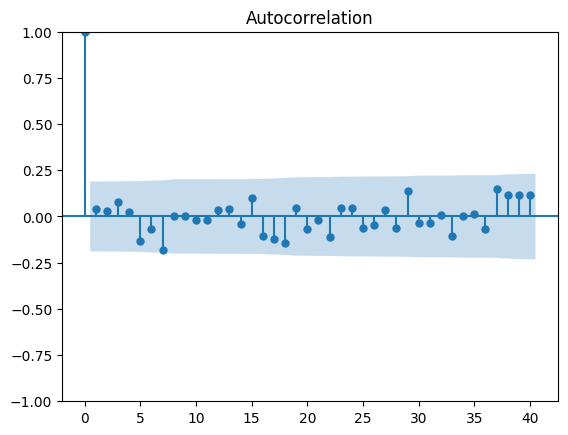

In [74]:
# \subsubsection{Exploring Auto-Correlation}
# Analyze the Auto-Correlation Function (ACF)
def check_significant_autocorrelation(series, threshold=0.2):
    # Plot ACF with confidence intervals
    plot_acf(series, lags=40)
    
    # Compute ACF values
    acf_values = acf(series, nlags=40)
    
    # Check if there is significant auto-correlation
    if not any(abs(acf_values[1:]) > threshold):  # Threshold for significant auto-correlation
        print("No significant auto-correlation found.")
    else:
        print("Significant auto-correlation found. By ->", np.sum(abs(acf_values[1:]) > threshold))
    
    return acf_values

# Check for significant auto-correlation in the target column of the training data
acf_values = check_significant_autocorrelation(train_df[target_col])

In [14]:
def granger_causality_tests_all_columns(data, target, maxlag=12):
    results = []
    excl_cols = ['rd_sale_Median', 'staff_sale_Median', 'adv_sale_Median']
    cols = [col for col in data.columns if col != target and col not in excl_cols]
    for col in cols:
        print(f"Granger Causality Test for {col}:")
        test_result = grangercausalitytests(data[[target, col]], maxlag=maxlag, verbose=True)
        for lag, result in test_result.items():
            p_value = result[0]['ssr_ftest'][1]
            is_causal = p_value < 0.05
            results.append([col, lag, p_value, is_causal])
    results_df = pd.DataFrame(results, columns=['column', 'lag', 'p_value', 'is_causal'])
    return results_df

# Example usage
results_df = granger_causality_tests_all_columns(train_df, target_col)

Granger Causality Test for NFIRM:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0303  , p=0.8622  , df_denom=104, df_num=1
ssr based chi2 test:   chi2=0.0312  , p=0.8599  , df=1
likelihood ratio test: chi2=0.0312  , p=0.8599  , df=1
parameter F test:         F=0.0303  , p=0.8622  , df_denom=104, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3851  , p=0.6814  , df_denom=101, df_num=2
ssr based chi2 test:   chi2=0.8083  , p=0.6676  , df=2
likelihood ratio test: chi2=0.8052  , p=0.6686  , df=2
parameter F test:         F=0.3851  , p=0.6814  , df_denom=101, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3258  , p=0.8067  , df_denom=98, df_num=3
ssr based chi2 test:   chi2=1.0472  , p=0.7898  , df=3
likelihood ratio test: chi2=1.0420  , p=0.7911  , df=3
parameter F test:         F=0.3258  , p=0.8067  , df_denom=98, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test

/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: 

parameter F test:         F=1.2927  , p=0.2688  , df_denom=89, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.9595  , p=0.4659  , df_denom=86, df_num=7
ssr based chi2 test:   chi2=7.8882  , p=0.3426  , df=7
likelihood ratio test: chi2=7.5953  , p=0.3696  , df=7
parameter F test:         F=0.9595  , p=0.4659  , df_denom=86, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.9239  , p=0.5013  , df_denom=83, df_num=8
ssr based chi2 test:   chi2=8.9052  , p=0.3504  , df=8
likelihood ratio test: chi2=8.5308  , p=0.3834  , df=8
parameter F test:         F=0.9239  , p=0.5013  , df_denom=83, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.6030  , p=0.7909  , df_denom=80, df_num=9
ssr based chi2 test:   chi2=6.7159  , p=0.6667  , df=9
likelihood ratio test: chi2=6.4979  , p=0.6892  , df=9
parameter F test:         F=0.6030  , p=0.7909  , df_denom=80, df_num=9

Granger Causality
number of

/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: 

parameter F test:         F=0.6953  , p=0.7259  , df_denom=77, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=0.6534  , p=0.7770  , df_denom=74, df_num=11
ssr based chi2 test:   chi2=9.4218  , p=0.5830  , df=11
likelihood ratio test: chi2=8.9919  , p=0.6226  , df=11
parameter F test:         F=0.6534  , p=0.7770  , df_denom=74, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.1693  , p=0.3217  , df_denom=71, df_num=12
ssr based chi2 test:   chi2=18.9731 , p=0.0892  , df=12
likelihood ratio test: chi2=17.3136 , p=0.1382  , df=12
parameter F test:         F=1.1693  , p=0.3217  , df_denom=71, df_num=12
Granger Causality Test for divyield_Median:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=0.9976  , df_denom=104, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=0.9975  , df=1
likelihood ratio test: chi2=0.0000  , p=0.9975  , df=1
parameter F test:         F=0.0000  , p=0.99

/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: 

ssr based F test:         F=0.2798  , p=0.9785  , df_denom=80, df_num=9
ssr based chi2 test:   chi2=3.1160  , p=0.9595  , df=9
likelihood ratio test: chi2=3.0680  , p=0.9615  , df=9
parameter F test:         F=0.2798  , p=0.9785  , df_denom=80, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.2842  , p=0.9829  , df_denom=77, df_num=10
ssr based chi2 test:   chi2=3.6174  , p=0.9630  , df=10
likelihood ratio test: chi2=3.5522  , p=0.9653  , df=10
parameter F test:         F=0.2842  , p=0.9829  , df_denom=77, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=0.2753  , p=0.9887  , df_denom=74, df_num=11
ssr based chi2 test:   chi2=3.9692  , p=0.9708  , df=11
likelihood ratio test: chi2=3.8901  , p=0.9730  , df=11
parameter F test:         F=0.2753  , p=0.9887  , df_denom=74, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=0.2492  , p=0.9945  , df_denom=71, df_num=12
ssr based chi2 t

/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: 

ssr based F test:         F=0.6337  , p=0.7650  , df_denom=80, df_num=9
ssr based chi2 test:   chi2=7.0576  , p=0.6311  , df=9
likelihood ratio test: chi2=6.8174  , p=0.6561  , df=9
parameter F test:         F=0.6337  , p=0.7650  , df_denom=80, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.5770  , p=0.8279  , df_denom=77, df_num=10
ssr based chi2 test:   chi2=7.3430  , p=0.6927  , df=10
likelihood ratio test: chi2=7.0809  , p=0.7178  , df=10
parameter F test:         F=0.5770  , p=0.8279  , df_denom=77, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=0.5033  , p=0.8952  , df_denom=74, df_num=11
ssr based chi2 test:   chi2=7.2567  , p=0.7779  , df=11
likelihood ratio test: chi2=6.9981  , p=0.7992  , df=11
parameter F test:         F=0.5033  , p=0.8952  , df_denom=74, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=0.5261  , p=0.8909  , df_denom=71, df_num=12
ssr based chi2 t

/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: 

ssr based F test:         F=0.6417  , p=0.7737  , df_denom=77, df_num=10
ssr based chi2 test:   chi2=8.1672  , p=0.6125  , df=10
likelihood ratio test: chi2=7.8447  , p=0.6440  , df=10
parameter F test:         F=0.6417  , p=0.7737  , df_denom=77, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=1.0320  , p=0.4278  , df_denom=74, df_num=11
ssr based chi2 test:   chi2=14.8798 , p=0.1881  , df=11
likelihood ratio test: chi2=13.8432 , p=0.2418  , df=11
parameter F test:         F=1.0320  , p=0.4278  , df_denom=74, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.0002  , p=0.4580  , df_denom=71, df_num=12
ssr based chi2 test:   chi2=16.2284 , p=0.1810  , df=12
likelihood ratio test: chi2=14.9940 , p=0.2418  , df=12
parameter F test:         F=1.0002  , p=0.4580  , df_denom=71, df_num=12
Granger Causality Test for short_debt_Median:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2616  , p=

/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: 

ssr based F test:         F=0.3376  , p=0.9744  , df_denom=74, df_num=11
ssr based chi2 test:   chi2=4.8677  , p=0.9374  , df=11
likelihood ratio test: chi2=4.7495  , p=0.9427  , df=11
parameter F test:         F=0.3376  , p=0.9744  , df_denom=74, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=0.2677  , p=0.9924  , df_denom=71, df_num=12
ssr based chi2 test:   chi2=4.3433  , p=0.9764  , df=12
likelihood ratio test: chi2=4.2479  , p=0.9785  , df=12
parameter F test:         F=0.2677  , p=0.9924  , df_denom=71, df_num=12
Granger Causality Test for intcov_Median:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3681  , p=0.5454  , df_denom=104, df_num=1
ssr based chi2 test:   chi2=0.3787  , p=0.5383  , df=1
likelihood ratio test: chi2=0.3780  , p=0.5387  , df=1
parameter F test:         F=0.3681  , p=0.5454  , df_denom=104, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1215  , p=0.8857 

/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: 

In [21]:
causal_cols = results_df[results_df['is_causal']].sort_values('p_value').to_dict(orient='records')
# Get the first unique 15 columns
# unique_cols = results_df[results_df['is_causal']].sort_values('p_value').drop_duplicates('column')['column'].head(15)

# Filter results_df to only include rows where 'column' is in unique_15_cols
# filtered_df = results_df[(results_df['column'].isin(unique_15_cols)) & (results_df['is_causal'])].sort_values('p_value')
# top3_df = results_df[results_df['is_causal']].groupby('column').apply(lambda x: x.nsmallest(3, 'p_value')).reset_index(drop=True)

In [22]:
train_lagged_df = train_df.copy()
test_lagged_df = test_df.copy()
lagged_cols = []

# Create lagged features for the training and test data
for elem in causal_cols:
    lag = elem['lag']
    column = elem['column']
    column_name = f'{column}_lag{lag}'
    train_lagged_df[column_name] = train_df[column].shift(lag)
    test_lagged_df[column_name] = test_df[column].shift(lag)
    lagged_cols.append(column_name)

train_lagged_df = train_lagged_df.dropna()[lagged_cols + [target_col]]
test_lagged_df = test_lagged_df.dropna()[lagged_cols + [target_col]]

RMSE: 0.2601469101447851
MAE: 0.19544272826981496
MAPE: 252.85%


/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


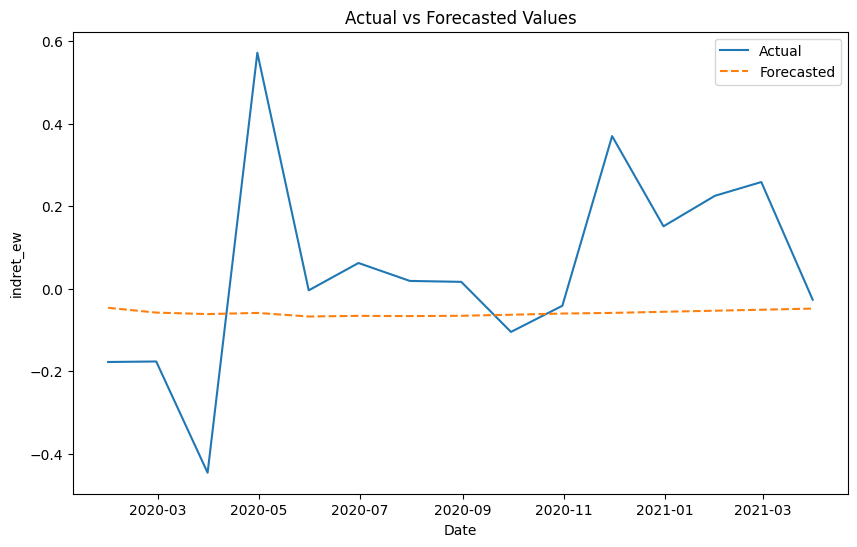

In [23]:
import pandas as pd
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Fit the VAR model
var_model = VAR(train_lagged_df)
var_result = var_model.fit(maxlags=1)  # Adjust maxlags if necessary

# Forecasting with the trained model
forecast = var_result.forecast(train_lagged_df.values, steps=len(test_lagged_df))

# Convert forecast to DataFrame for better interpretation
forecast_df = pd.DataFrame(forecast, index=test_lagged_df.index, columns=train_lagged_df.columns)

# Extract the forecasted target variable
forecast_target = forecast_df[target_col]

# Evaluate the forecast using RMSE, MAE, and MAPE
rmse = np.sqrt(mean_squared_error(test_lagged_df[target_col], forecast_target))
mae = mean_absolute_error(test_lagged_df[target_col], forecast_target)
mape = np.mean(np.abs((test_lagged_df[target_col] - forecast_target) / test_lagged_df[target_col])) * 100

# Print the evaluation metrics
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape:.2f}%')

# Plot actual vs forecasted values
plt.figure(figsize=(10, 6))
plt.plot(test_lagged_df.index.get_level_values('public_date'), test_lagged_df[target_col], label='Actual')
plt.plot(test_lagged_df.index.get_level_values('public_date'), forecast_target, label='Forecasted', linestyle='--')
plt.xlabel('Date')
plt.ylabel(target_col)
plt.title('Actual vs Forecasted Values')
plt.legend()
plt.show()

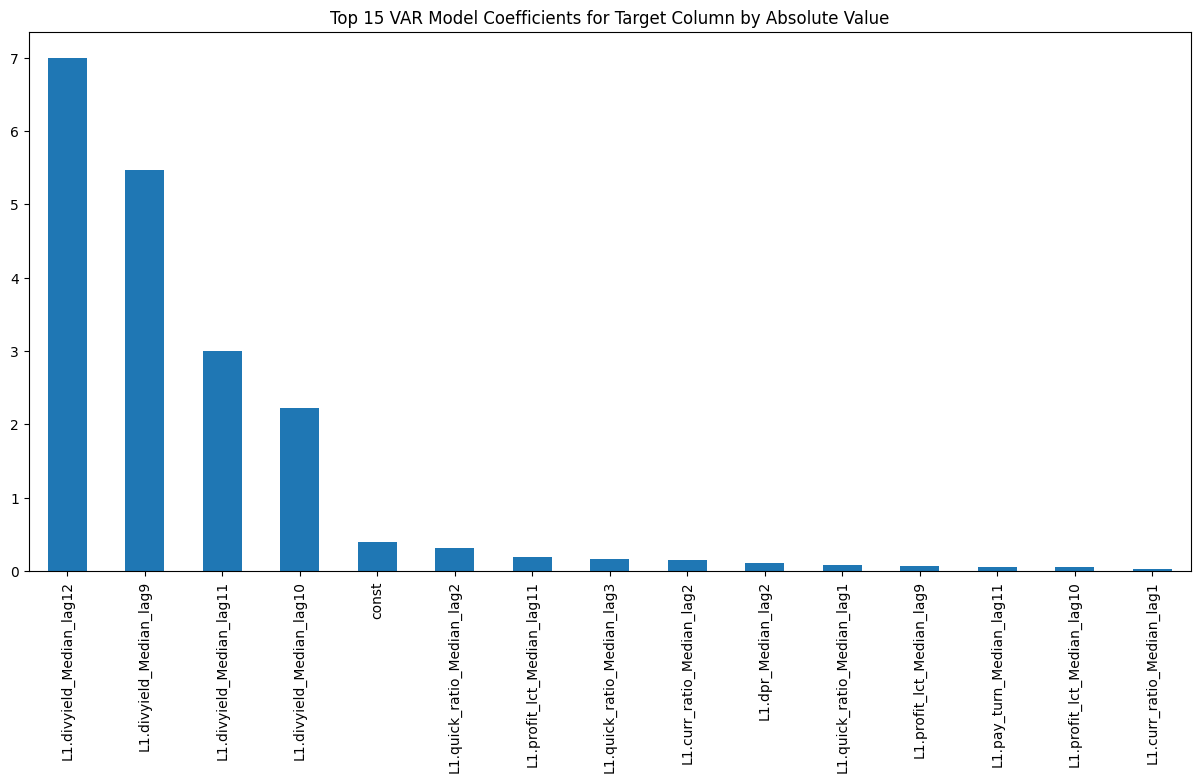

In [24]:
coefficients = var_result.params

# Extract coefficients for the target column
target_coefficients = coefficients[target_col]

# Get absolute values of coefficients
abs_target_coefficients = target_coefficients.abs()

# Sort coefficients by absolute value and select top 15
top_15_target_coefficients = abs_target_coefficients.sort_values(ascending=False).head(15)

# Plot top 15 coefficients
top_15_target_coefficients.plot(kind='bar', figsize=(15, 7))
plt.title('Top 15 VAR Model Coefficients for Target Column by Absolute Value')
plt.show()

In [25]:
train_lagged_df.corr()[target_col].sort_values(ascending=False)

indret_ew                  1.000000
quick_ratio_Median_lag1    0.275475
curr_ratio_Median_lag1     0.273353
quick_ratio_Median_lag2    0.207180
curr_ratio_Median_lag2     0.200614
quick_ratio_Median_lag3    0.179456
pay_turn_Median_lag12      0.162141
pay_turn_Median_lag11      0.126266
dpr_Median_lag2            0.077889
divyield_Median_lag9      -0.043608
divyield_Median_lag11     -0.060415
divyield_Median_lag10     -0.062930
profit_lct_Median_lag11   -0.064510
divyield_Median_lag12     -0.067109
profit_lct_Median_lag10   -0.075487
profit_lct_Median_lag9    -0.075931
Name: indret_ew, dtype: float64

/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/marcello/Documents/GitHub/uva-msc-ds-thesis/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  retur

                               SARIMAX Results                                
Dep. Variable:              indret_ew   No. Observations:                  108
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 103.302
Date:                Thu, 23 May 2024   AIC                           -200.605
Time:                        09:50:36   BIC                           -192.586
Sample:                             0   HQIC                          -197.354
                                - 108                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0985      0.085      1.160      0.246      -0.068       0.265
ma.L1         -0.9877      0.049    -20.130      0.000      -1.084      -0.892
sigma2         0.0082      0.001      7.011      0.0

TypeError: 'value' must be an instance of str or bytes, not a tuple

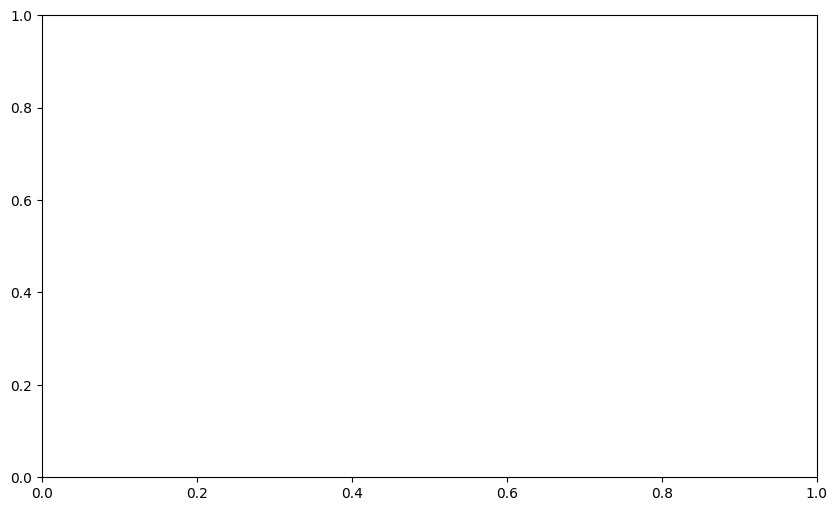

In [26]:
# \subsubsection{Time-Series Based Models}
# Fit an ARIMA model to the data and evaluate performance
def fit_arima_model(train, test, target, order=(1, 1, 1)):
    model = ARIMA(train[target], order=order)
    model_fit = model.fit()
    print(model_fit.summary())

    # Forecast
    forecast = model_fit.forecast(steps=len(test))
    
    # Plot actual vs forecasted values
    plt.figure(figsize=(10, 6))
    plt.plot(train[target], label='Training Data')
    plt.plot(test.index, test[target], label='Test Data')
    plt.plot(test.index, forecast, label='Forecast', color='red')
    plt.title('ARIMA Model Forecast')
    plt.xlabel('Date')
    plt.ylabel(target)
    plt.legend()
    plt.show()
    
    # Calculate performance metrics
    mse = np.mean((forecast - test[target]) ** 2)
    print(f'Mean Squared Error: {mse}')
    return model_fit, forecast

# Fit ARIMA model and evaluate
if is_stationary:
    arima_model, arima_forecast = fit_arima_model(train_df, test_df, target_col)
else:
    print(f"The series {target_col} is not stationary. ARIMA model fitting is not appropriate.")

In [ ]:
# \subsubsection{Copula Entropy}
def calculate_copula_entropy(data):
    copula = GaussianMultivariate()
    copula.fit(data)
    entropy = copula.entropy()
    print(f'Copula Entropy: {entropy}')
    return entropy

# Calculate copula entropy for training data
copula_entropy = calculate_copula_entropy(train_df)

In [ ]:
# \subsubsection{Transfer Entropy}
def calculate_transfer_entropy(data, source_col, target_col, k=1, tau=1):
    source = data[source_col].values
    target = data[target_col].values
    te = transfer_entropy(source, target, k=k, tau=tau)
    print(f'Transfer Entropy from {source_col} to {target_col}: {te}')
    return te

# Example usage for Transfer Entropy
# calculate_transfer_entropy(train_df, 'source_col', target_col)

# Replace 'source_col' with the actual name of the source column
